# IVOL Puzzle & Arbitrage Asymmetry

This project aims to study the relationship between idiosyncratic volatility and expected return on equities. It attempts to recreate the study done by Stambaugh et al in 2015, with updated dataset up to 2024.

Idiosyncratic volatility is defined as the volatility of residuals when historical returns are regressed against Fama-French 3 factors. In line with Stambaugh's approach, we calculate IVOL over a historical period of one month. This yields a time series of IVOL values for each stock in our universe. 

At the same time, we use a composite, cross sectional measure for mispricing based on 10 return anomalies (the financial distress score is not easily retrievable). Each return anomaly is a time series object for each stock in our universe. To arrive at a composite measure for each time stamp, for each return anomaly, we rank each stock by the return anomaly. This yields 10 different rankings for each stock on any given day. We take the arithmetic mean of the 10 rankings to be the composite cross sectional measure of mispricing. 

With IVOL and mispricing measure, for each date, we sort stocks on IVOL and mispricing, grouping into 5 groups along each dimension. This forms 25 different baskets of stocks. We form each into a value-weighted portfolio. We then calculate the return on this portfolio for the next month, and regress against fama-french 3 factors to find the return that survive factor adjustment. 




## Notebook Set Up

In [88]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap
from datetime import datetime
import numpy as np
import seaborn as sns
import wrds
import statsmodels.api as sm
from tqdm import tqdm
from pandas.tseries.offsets import MonthBegin, MonthEnd

plt.style.use('seaborn-v0_8-notebook')
eps = 1e-8
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

conn = wrds.Connection()
start = "1965-01-01"
end = "2025-01-01"

Loading library list...
Done


## Security identification
In line with Stambaugh et al's methodology, we use all NYSE/AMex/NASDAQ stocks with share prices greater than five dollars. We expand the dataset to cover up to 2024.

The code used to extract all tickers from the three relevant exchanges was 

```python
tickers = conn.raw_sql(
    f"""
    SELECT permno, ticker, namedt
    FROM crsp.msenames
    WHERE namedt BETWEEN '{start}' AND '{end}'
    AND exchcd in (1, 2, 3)
    """
)
```

From documentation, we understand that PERMNO is a unique five-digit permanent identifier assigned by CRSP to each security in the file. Unlike CUSIP, TICKER, and COMNAM, the PERMNO neither changes during an issue's trading history, nor is reassigned after an issue ceases trading. The user may track a security through its entire trading history in CRSP's files with one PERMNO, regardless of name changes or capital structure changes. A security that is included on both CRSP's Nasdaq and NYSE/AMEX files will have the same CRSP permanent number in both files.

Therefore, we have elected to work with `permnos` when identifying securities, instead of using individual tickers


## IVOL calculation

To calculate idiosyncratic volatility, we retrieved daily FF 3 factors. 

```python
factors = conn.raw_sql(
    f"""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '{start}' AND '{end}'
    """,
    date_cols = ['date']
).set_index('date')

factors = (
    factors.replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)
```

We want a time-series at month-end frequency for each security in our universe, where `ivol_df.loc[t, p]` refers to the volatility of the residuals after regressing the daily returns for security `p` for month `t` against FF 3 factors. 

```python
ivol_df = pd.DataFrame(
    index = month_end_dates,
    columns = tickers['permno'].unique()
)

for i, permno in enumerate(ivol_df.columns[:100]):
    ret_df = (
        conn.raw_sql(
        f"""
        SELECT date, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
        AND permno = {permno}
        """,
        date_cols = ['date'])
        .set_index('date')
        .merge(
            factors,
            left_index=True,
            right_index=True,
            how='left'
        )
    )
    ret_df['ex_ret'] = ret_df['ret'] - ret_df['rf']

    for idx in ivol_df.index:
        time_range_mask = (
            (ret_df.index >= idx - pd.DateOffset(months = 1)) * (ret_df.index <= idx)
        )
        X = np.asarray(
            ret_df[['mktrf', 'smb', 'hml']][time_range_mask]
        )
        y = np.asarray(
            ret_df[['ex_ret']][time_range_mask]
        )

        if X.shape[0] != 0:
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            ivol = np.std(
                model.resid
            )
            ivol_df.loc[idx, col] = ivol


ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
```

## IVOL EDA

In [ ]:
ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)
ivol_df

We visualize the IVOL for Apple, Microsoft and Intuitive Surgical.

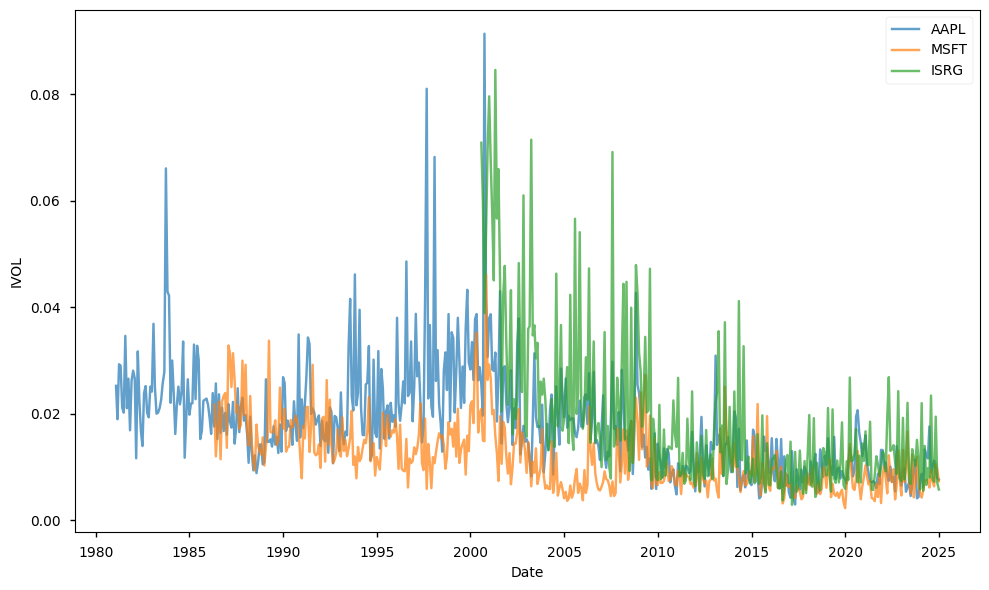

In [5]:
tickers = ['AAPL', 'MSFT', 'ISRG']
tickers_permno_map = conn.raw_sql(
    f"""
    SELECT DISTINCT permno, ticker
    FROM crsp.msenames
    WHERE ticker in ({','.join(["'" + t + "'" for t in tickers])})
    """
)
tickers_permno_map

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

for ticker in tickers:
    permno = tickers_permno_map[
        tickers_permno_map['ticker'] == ticker
    ]['permno'].iloc[0]
    ax.plot(
        ivol_df[str(permno)],
        label = ticker,
        alpha = .7
    )

ax.set_xlabel('Date')
ax.set_ylabel('IVOL')
ax.legend()

plt.tight_layout()
plt.show()

We visualize the aggregate IVOL across all securities.

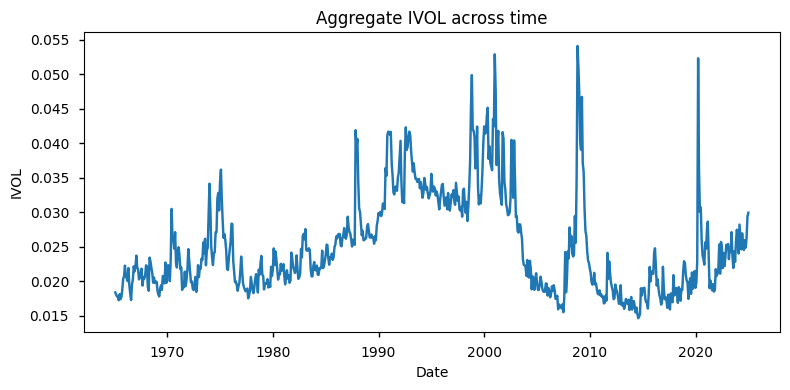

In [7]:
ivol_by_date = ivol_df.apply(lambda x: x.mean(), axis = 1)

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(
    ivol_by_date
)
ax.set_xlabel('Date')
ax.set_ylabel('IVOL')

ax.set_title("Aggregate IVOL across time")

plt.tight_layout()
plt.show()

We visualize the IVOL for 10 randomly picked securities.

Text(0.5, 1.0, '10 randomly picked IVOLs')

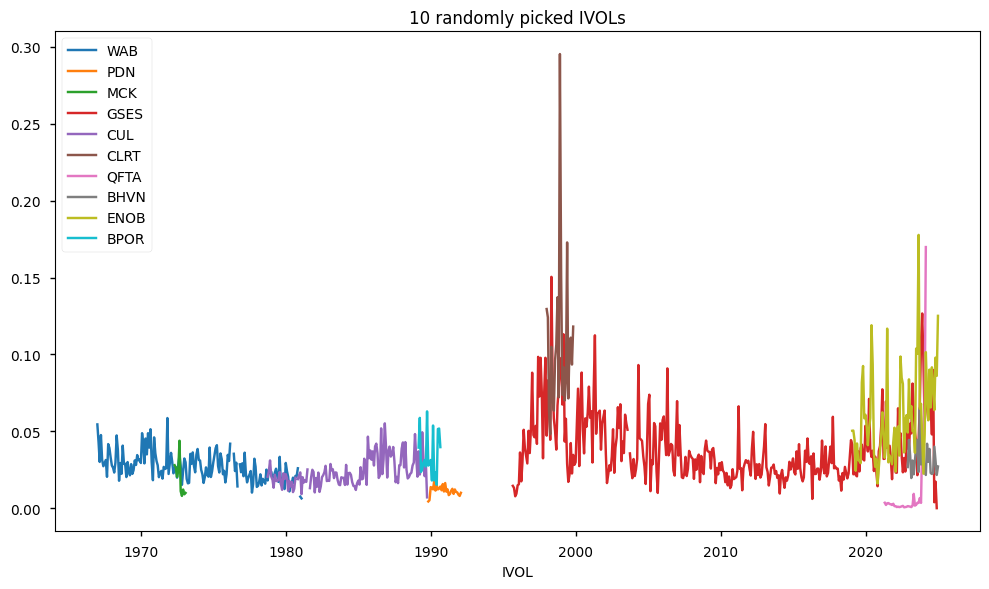

In [8]:
fig, ax = plt.subplots(1, 1)
for rng_col in np.random.randint(0, ivol_df.shape[1], size = 10):
    ticker = conn.raw_sql(
        f"""
            SELECT DISTINCT ticker
            FROM crsp.msenames
            WHERE permno = {ivol_df.columns[rng_col]}
        """
    )['ticker'][0]
    ax.plot(
        ivol_df.iloc[:, rng_col],
        label = ticker
    )
ax.set_xlabel('Date')
ax.set_xlabel('IVOL')
ax.legend()
ax.set_title("10 randomly picked IVOLs")

## IVOL Long Short Strategy

We consider a LS strategy where we long the 10% lowest IVOL stocks every month, and short the 10% highest IVOL stocks every month. If there is truly a negative IVOL effect on expected return, this strategy should generate excess returns. 

In [ ]:
quantile_low = 0.10
quantile_high = 0.90

long_short_dict = {}

for date, row in ivol_df.iterrows():
    print("======" * 10)
    ivol_today = row.dropna()

    prices = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date =  '{date.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    ).set_index('permno')
    if prices.shape[0] == 0:
        prices = conn.raw_sql(
            f"""
                SELECT DISTINCT ON (permno) permno, prc, date
                FROM crsp.msf
                WHERE date <= '{date.strftime("%Y-%m-%d")}'
                ORDER BY permno, date DESC
            """
        )

        prices = prices[prices['prc']>=5].set_index("permno")

    ivol_filtered = ivol_today[ivol_today.index.isin(prices.index)]
    
    if len(ivol_filtered) < 10:
        print(f"Skipping {date},  not enough tradeable securities")
        continue

    low_thresh = ivol_filtered.quantile(quantile_low)
    high_thresh = ivol_filtered.quantile(quantile_high)
    print(f"low threshold: {low_thresh:.4f}, high threshold: {high_thresh:.4f}")

    long_stocks = ivol_filtered[ivol_filtered <= low_thresh].index.tolist()
    short_stocks = ivol_filtered[ivol_filtered >= high_thresh].index.tolist()

    print(
        f"long leg mean IVOL: {ivol_df.loc[date, long_stocks].mean():.4f}"
    )
    print(
        f"short leg mean IVOL: {ivol_df.loc[date, short_stocks].mean():.4f}"
    )

    print(f"Processed {date}, {len(ivol_filtered)} total, {len(long_stocks)} longs, {len(short_stocks)} shorts")

    long_short_dict[date] = {
        'long': long_stocks,
        'short': short_stocks
    }


ls_returns = []

for date, positions in long_short_dict.items():
    next_month = (date + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

    tickers = positions['long'] + positions['short']

    ret_data = conn.raw_sql(
        f"""
        SELECT permno, ret
        FROM crsp.msf
        WHERE date = '{next_month}'
        """
    )

    long_returns = ret_data[ret_data['permno'].isin(positions['long'])]['ret']
    short_returns = ret_data[ret_data['permno'].isin(positions['short'])]['ret']

    if len(long_returns) == 0 or len(short_returns) == 0:
        continue

    # we work with equal-weighted portfolio for now
    long_ret = long_returns.mean()
    short_ret = short_returns.mean()

    ls_return = long_ret - short_ret

    ls_returns.append({
        'date': date,
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': ls_return
    })
    print(f"Processed {date}, LS return: {ls_return}")

ls_df = pd.DataFrame(ls_returns).set_index('date')

In [ ]:
calendar_month_ends = ivol_df.index
crsp_month_ends = conn.raw_sql(
    """
    SELECT DISTINCT date
    FROM crsp.msf
    WHERE date BETWEEN '1965-01-01' AND '2025-01-01'
    ORDER BY date
    """
)['date']
crsp_month_ends = pd.to_datetime(crsp_month_ends)
calendar_to_crsp_map = {}
for cal_date in calendar_month_ends:
    same_month_crsp = crsp_month_ends[
        (crsp_month_ends.dt.year == cal_date.year) &
        (crsp_month_ends.dt.month == cal_date.month)
    ]
    calendar_to_crsp_map[cal_date] = same_month_crsp.max() if not same_month_crsp.empty else pd.NaT
calendar_to_crsp_map = pd.Series(calendar_to_crsp_map)

calendar_to_crsp_map

In [ ]:
quantile_low = 0.10
quantile_high = 0.90
long_short_dict = {}

for date, row in ivol_df.iterrows():
    print("=" * 60)
    print(f"Processing {date.strftime('%Y-%m-%d')}")

    ivol_today = row.dropna()

    crsp_price_date = calendar_to_crsp_map.get(date)

    if pd.isna(crsp_price_date):
        print(f"Skipping {date} — no mapped CRSP date available")
        continue

    crsp_price_date_str = crsp_price_date.strftime("%Y-%m-%d")

    permnos_filtered = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date = '{crsp_price_date_str}'
        AND prc >= 5
        """
    ).set_index('permno')

    if permnos_filtered.shape[0] == 0:
        print(f"Skipping {date} — no tradable stocks at {crsp_price_date_str}")
        continue

    ivol_filtered = ivol_today[ivol_today.index.isin(permnos_filtered.index)]

    if len(ivol_filtered) < 10:
        print(f"Skipping {date} — fewer than 10 tradable securities")
        continue

    low_thresh = ivol_filtered.quantile(quantile_low)
    high_thresh = ivol_filtered.quantile(quantile_high)

    long_stocks = ivol_filtered[ivol_filtered <= low_thresh].index.tolist()
    short_stocks = ivol_filtered[ivol_filtered >= high_thresh].index.tolist()

    print(f"Low threshold: {low_thresh:.4f}, High threshold: {high_thresh:.4f}")
    print(f"Long IVOL mean: {ivol_filtered[long_stocks].mean():.4f}")
    print(f"Short IVOL mean: {ivol_filtered[short_stocks].mean():.4f}")
    print(f"{len(ivol_filtered)} total | {len(long_stocks)} long | {len(short_stocks)} short")

    long_short_dict[date] = {
        'long': long_stocks,
        'short': short_stocks
    }


ls_returns = []

for date, positions in long_short_dict.items():
    crsp_ret_date = calendar_to_crsp_map.get(date + pd.offsets.MonthEnd(1))

    if pd.isna(crsp_ret_date):
        print(f"Skipping {date} — no CRSP return date for next month")
        continue

    crsp_ret_date_str = crsp_ret_date.strftime("%Y-%m-%d")
    tickers = positions['long'] + positions['short']

    ret_data = conn.raw_sql(
        f"""
        SELECT permno, ret
        FROM crsp.msf
        WHERE date = '{crsp_ret_date_str}'
        """
    )

    long_returns = ret_data[ret_data['permno'].isin(positions['long'])]['ret']
    short_returns = ret_data[ret_data['permno'].isin(positions['short'])]['ret']

    if long_returns.empty or short_returns.empty:
        print(f"Skipping {date} — missing returns for long or short leg")
        continue

    long_ret = long_returns.mean()
    short_ret = short_returns.mean()
    ls_ret = long_ret - short_ret

    ls_returns.append({
        'date': date,
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': ls_ret
    })

    print(f"Processed {date}, LS return: {ls_ret:.4f}")

ls_df = pd.DataFrame(ls_returns).set_index('date')

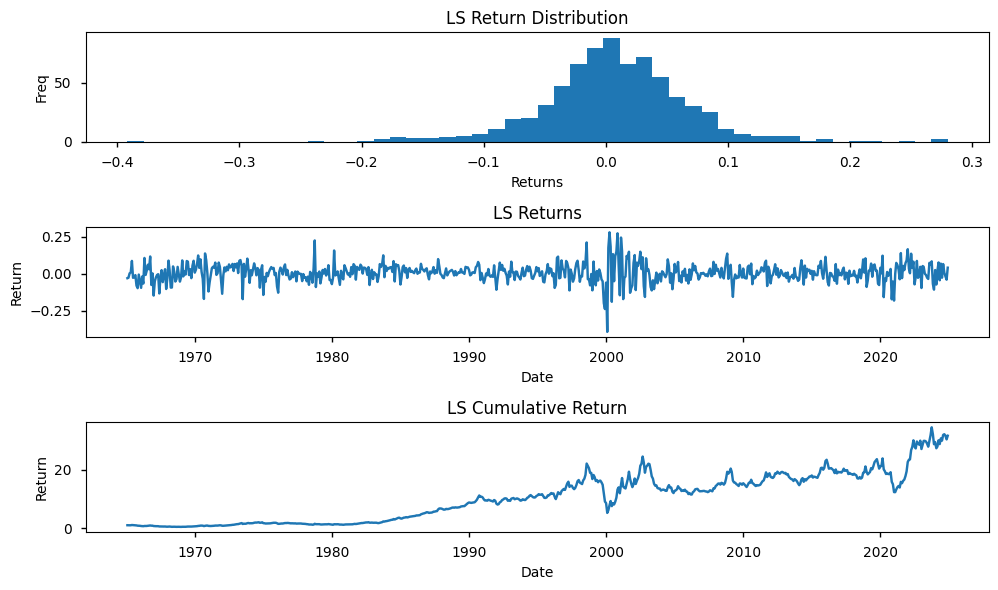

Text(0.5, 1.0, 'Cumulative Return')

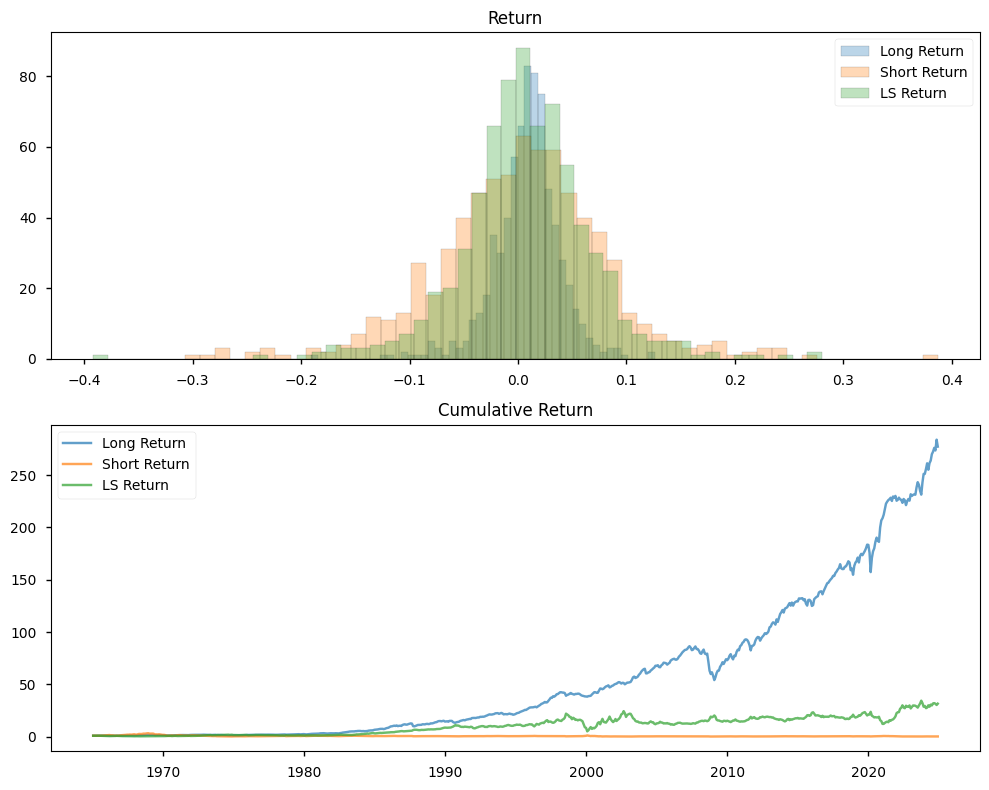

In [207]:
fig, axes = plt.subplots(3, 1, figsize= (10, 6))
axes[0].hist(
    ls_df['ls_ret'],
    bins = 50,
)

axes[0].set_xlabel("Returns")
axes[0].set_ylabel("Freq")

axes[1].plot(
    ls_df['ls_ret']
)

axes[1].set_xlabel("Date")
axes[1].set_ylabel("Return")
axes[1].set_title("LS Returns")

axes[2].plot(
    (ls_df['ls_ret'] + 1).cumprod()
)

axes[2].set_xlabel("Date")
axes[2].set_ylabel("Return")

axes[0].set_title("LS Return Distribution")
axes[2].set_title("LS Cumulative Return")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 1, figsize = (10, 8))

axes[0].hist(
    ls_df['long_ret'],
    label = "Long Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].hist(
    ls_df['short_ret'],
    label = "Short Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].hist(
    ls_df['ls_ret'],
    label = "LS Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].legend()

axes[0].set_title("Return")

axes[1].plot(
    (ls_df['long_ret'] + 1).cumprod(),
    label = "Long Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['short_ret'] + 1).cumprod(),
    label = "Short Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['ls_ret'] + 1).cumprod(),
    label = "LS Return",
    alpha = .7
)

axes[1].legend()
axes[1].set_title("Cumulative Return")


The results from the long-short strategy—longing the lowest IVOL decile and shorting the highest—are broadly consistent with the predictions of Stambaugh, Yu, and Yuan (2015). In their framework, mispricing is more likely to persist in stocks with high idiosyncratic volatility due to limits to arbitrage. Arbitrageurs, being risk-averse and capital-constrained, are less willing to short overpriced stocks when doing so entails high idiosyncratic risk. As a result, high-IVOL stocks are more likely to remain overvalued and subsequently underperform.

The evidence here aligns with that expectation. The long-short portfolio delivers a steady positive return over time, with the cumulative performance primarily driven by the long leg. This suggests that low-IVOL stocks, which are more easily arbitraged and less prone to mispricing, offer more reliable future returns. Meanwhile, the short leg contributes little, consistent with the idea that while high-IVOL stocks are overpriced, arbitrage frictions limit the effectiveness of betting against them.

Overall, the observed return profile supports the mechanism proposed in Stambaugh et al.—that idiosyncratic volatility serves as a proxy for the degree of arbitrage difficulty and thus helps explain the cross-section of mispricing and expected returns.

In [208]:
factors = (
    conn.raw_sql(
        f"""
        SELECT date, mktrf, smb, hml, rf
        FROM ff.factors_monthly
        WHERE date BETWEEN '{start}' AND '{end}'
        """,
        date_cols = ['date']
    )
    .set_index('date')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

factors.index = factors.index + pd.offsets.MonthEnd(0)

ls_df_merged = ls_df.merge(
    factors,
    left_index = True,
    right_index = True
)

y = np.asarray(ls_df_merged['ls_ret'] - ls_df_merged['rf'])
X = np.asarray(
    ls_df_merged[['mktrf', 'smb', 'hml']]
)
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.901
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00223
Time:                        20:43:30   Log-Likelihood:                 990.49
No. Observations:                 719   AIC:                            -1973.
Df Residuals:                     715   BIC:                            -1955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.461      0.145      -0.001       0.008
x1            -0.0968      0.054     -1.806      0.071      -0.202       0.008
x2            -0.1005      0.078     -1.292      0.197      -0.253       0.052
x3             0.1679      0.078      2.164      0.031       0.016       0.320
==============================================================================
Omnibus:                       87.367   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              557.349
Skew:                          -0.306   Prob(JB):                    9.40e-122
Kurtosis:                       7.270   Cond. No.                         35.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Retrieving return anomalies

The 9 return anomalies are retrieved in a separate notebook.

## Generating aggregate mispricing measure

To generate the aggregate mispricing measure, we follow Stambaugh et al's methodology. For each return anomaly, we rank all securities for which the anomaly can be calculated. 

For each date, for each anomaly, we sort all stocks from most underpiced to most overpriced. After assigning percentile rankings to each stock for each return anomaly, we filter for stocks that have at least 5 return anomalies that can be calculated. The overall aggregate mispricing measure is the arithmetic mean of the individual return anomaly scores.

In [ ]:
anomalies_df = pd.read_csv('./Data/anomalies_raw_new.csv')
anomalies_df

In [ ]:
anomalies_df = anomalies_df[
    ~anomalies_df['variable'].isin(['me', 'prc', 'ret'])
]

anomalies_df.set_index(['date', 'variable'], inplace=True)
anomalies_df.columns = anomalies_df.columns.astype(int)

columns_to_reverse = [
    'niq_at', # return on assets
    'ret_12_1', # momentum
    'gp_at'
]

for idx in anomalies_df.index:
    var = idx[1]
    if var in columns_to_reverse:
        anomalies_df.loc[idx] = - anomalies_df.loc[idx]

anomalies_pct = pd.DataFrame(
    index = anomalies_df.index,
    columns = anomalies_df.columns
)
for i, idx in enumerate(anomalies_pct.index):
    print(f"Processing {i} out of {anomalies_pct.shape[0]}")
    anomalies_pct.loc[idx] = anomalies_df.loc[idx].rank(pct=True)

In [15]:
aggregated = {}

for i, stock in enumerate(anomalies_pct.columns):
    print(f"Processing column {i}/{anomalies_pct.shape[1]}", end = '\r')
    temp = (
        anomalies_pct[stock]
        .unstack('variable') 
        .apply(lambda row: row.dropna().mean() if row.dropna().shape[0] >= 5 else np.nan, axis=1)
    )
    aggregated[stock] = temp

aggregate_mispricing_df = pd.concat(aggregated, axis=1)
aggregate_mispricing_df.index = pd.to_datetime(aggregate_mispricing_df.index)

In [16]:
aggregate_mispricing_df.to_csv('./Data/aggregate_mispricing.csv')

## Double sorting stocks on IVOL and mispricing

The next section intends to form 25 value-weighted portfolio of stocks double sorted on IVOL and mispricing measure. 

Along each dimension, we split our stocks into 5 quintiles. The naming scheme of our portfolio is as follows
- each security gets assigned a label 0-4 for mispricing, where 0 is the most overpriced and 4 is the most underpriced, let this be $l1$
- each security gets assigned a label 0-4 for IVOL, where 0 is the lowest IVOL and 4 is the highest IVOL,  let this be $l2$

The overall portfolio that each ticker falls under will be $k$
$$
k = 5 \times l1 + l2
$$

#### Sorting on IVOL

Since we previously calculated IVOLs for all securities, regardless of whether they meet our $5 trading price requirement, we want to filter these out. The filtering was done when we processed the return anomalies and mispricing measures, hence the difference in shape between `ivol_df` and `aggregate_mispricing_df`.

In [14]:
ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
aggregate_mispricing_df = pd.read_csv('./Data/aggregate_mispricing.csv', index_col=0)

ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)

aggregate_mispricing_df.index = pd.to_datetime(aggregate_mispricing_df.index)
aggregate_mispricing_df.columns = aggregate_mispricing_df.columns.astype(int)

filtered_cols = ivol_df.columns[
    ivol_df.columns.isin(aggregate_mispricing_df.columns)
]

ivol_df = ivol_df[filtered_cols]
aggregate_mispricing_df = aggregate_mispricing_df[filtered_cols]

In [ ]:
def map_quantile(x, quantiles):
    if x <= quantiles[0]:
        return 0
    elif x <= quantiles[1]:
        return 1
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 3
    else:
        return 4

def map_quantile_reversed(x, quantiles):
    if x <= quantiles[0]:
        return 4
    elif x <= quantiles[1]:
        return 3
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 1
    else:
        return 0
    
ivol_quintiles = pd.DataFrame(index=ivol_df.index, columns=filtered_cols)
mispricing_quintiles = pd.DataFrame(index=aggregate_mispricing_df.index, 
                                    columns=filtered_cols)

calendar_month_ends = pd.date_range('1965-01-01', '2025-01-01', freq='ME')
crsp_month_ends = conn.raw_sql(
    """
    SELECT DISTINCT date
    FROM crsp.msf
    WHERE date BETWEEN '1965-01-01' AND '2025-01-01'
    ORDER BY date
    """
)['date']
crsp_month_ends = pd.to_datetime(crsp_month_ends)

calendar_to_crsp_map = {}
for cal_date in calendar_month_ends:
    same_month_crsp = crsp_month_ends[
        (crsp_month_ends.dt.year == cal_date.year) & 
        (crsp_month_ends.dt.month == cal_date.month)
    ]
    if not same_month_crsp.empty:
        calendar_to_crsp_map[cal_date] = same_month_crsp.max()
    else:
        calendar_to_crsp_map[cal_date] = pd.NaT
calendar_to_crsp_map = pd.Series(calendar_to_crsp_map)


for idx in ivol_df.index:

    crsp_date = calendar_to_crsp_map[idx]
    permnos = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date = '{crsp_date.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    ).set_index('permno')
    
    valid_permnos = ivol_df.columns[
        ivol_df.columns.isin(permnos.index)
    ]
    ivol_today = ivol_df.loc[idx, valid_permnos]
    mispricing_t = aggregate_mispricing_df.loc[idx, valid_permnos]
    valid_permnos = ivol_today.index[~(ivol_today.isna() | mispricing_t.isna())]

    print(f"Processing {idx} - {len(valid_permnos)} permnos ranked")

    ivol_valid = ivol_today.loc[valid_permnos]
    ivol_q = np.quantile(ivol_valid, [0.2, 0.4, 0.6, 0.8])
    ivol_ranked = ivol_valid.apply(lambda x: map_quantile(x, ivol_q))
    ivol_quintiles.loc[idx, ivol_ranked.index] = ivol_ranked

    mispricing_valid = mispricing_t.loc[valid_permnos]
    mispricing_q = np.quantile(mispricing_valid, [0.2, 0.4, 0.6, 0.8])
    mispricing_ranked = mispricing_t.apply(lambda x: map_quantile_reversed(x, mispricing_q))
    mispricing_quintiles.loc[idx, mispricing_ranked.index] = mispricing_ranked


In [17]:
ivol_quintiles.to_csv('./Data/ivol_quintiles.csv')
mispricing_quintiles.to_csv('./Data/mispricing_quintiles.csv')

In [2]:
ivol_quintiles = pd.read_csv('./Data/ivol_quintiles.csv', index_col=0)
mispricing_quintiles = pd.read_csv('./Data/mispricing_quintiles.csv', index_col=0)

ivol_quintiles.index = pd.to_datetime(ivol_quintiles.index)
mispricing_quintiles.index = pd.to_datetime(mispricing_quintiles.index)

ivol_quintiles.columns = ivol_quintiles.columns.astype(int)
mispricing_quintiles.columns = mispricing_quintiles.columns.astype(int)

In [ ]:
mispricing_aligned = mispricing_quintiles[ivol_quintiles.columns]
portfolio_allocation = 5 * mispricing_aligned + ivol_quintiles
portfolio_allocation

After creating the 25 portfolios, now we value-weight them and calculate the return on each of the 25 portfolios.

In [5]:
source_df = pd.read_csv(
    './Data/me_prc_ret.csv',
    index_col=0
)
source_df['date'] = pd.to_datetime(source_df['date'])

market_equity_df = source_df[
    source_df['variable'] == 'me'
].drop(columns='variable').set_index('date')

market_equity_df.columns = market_equity_df.columns.astype(int)

prc_df = source_df[
    source_df['variable'] == 'prc'
].drop(columns='variable').set_index('date')
prc_df.columns = prc_df.columns.astype(int)

ret_df = source_df[
    source_df['variable'] == 'ret'
].drop(columns='variable').set_index('date')
ret_df.columns = ret_df.columns.astype(int)


In [6]:
stacked_alloc = portfolio_allocation.stack()

df_long = stacked_alloc.reset_index()
df_long.columns = ['date', 'ticker', 'portfolio']

grouped = df_long.groupby(['date', 'portfolio'])['ticker'].apply(np.array).unstack(fill_value=np.array([]))

portfolio_comp = grouped.reindex(
    index=pd.date_range('1965-01-01', '2025-01-01', freq='ME'),
    columns=np.arange(25),
    fill_value=np.array([])
)


In [ ]:
portfolio_comp

In [ ]:
# portfolio_comp = pd.DataFrame(
#     columns= np.arange(25),
#     index = pd.date_range(
#         '1965-01-01',
#         '2025-01-01',
#         freq = 'ME'
#     )
# )

# for date in portfolio_comp.index:
#     print(f"Processing {date}")
#     for portfolio in portfolio_comp.columns:
#         portfolio_comp.loc[date, portfolio] = np.asarray(portfolio_allocation.columns[
#             portfolio_allocation.loc[date] == portfolio
#         ])

# portfolio_comp

In [ ]:
calendar_month_ends = pd.date_range('1965-01-01', '2025-01-01', freq='ME')
crsp_month_ends = conn.raw_sql(
    """
    SELECT DISTINCT date
    FROM crsp.msf
    WHERE date BETWEEN '1965-01-01' AND '2025-01-01'
    ORDER BY date
    """
)['date']
crsp_month_ends = pd.to_datetime(crsp_month_ends)

calendar_to_crsp_map = {}
for cal_date in calendar_month_ends:
    same_month_crsp = crsp_month_ends[
        (crsp_month_ends.dt.year == cal_date.year) & 
        (crsp_month_ends.dt.month == cal_date.month)
    ]
    if not same_month_crsp.empty:
        calendar_to_crsp_map[cal_date] = same_month_crsp.max()
    else:
        calendar_to_crsp_map[cal_date] = pd.NaT
calendar_to_crsp_map = pd.Series(calendar_to_crsp_map)

portfolio_ret = pd.DataFrame(
    columns=np.arange(25),
    index=calendar_month_ends
)

for i, d in enumerate(portfolio_ret.index[:-1]):
    print(f"Processing {d}")


    for p in portfolio_ret.columns:
        permnos_dp = portfolio_comp.loc[d, p]

        w_dp = market_equity_df.loc[d][permnos_dp]

        crsp_date = calendar_to_crsp_map.get(d + pd.offsets.MonthEnd(1))

        if pd.isna(crsp_date):
            print(f"No CRSP return data for {d + pd.offsets.MonthEnd(1)}")
            continue

        crsp_date_str = crsp_date.strftime("%Y-%m-%d")
        ret_data = conn.raw_sql(
            f"""
            SELECT permno, ret
            FROM crsp.msf
            WHERE date = '{crsp_date_str}'
            """
        ).set_index('permno')

        ret_dp = ret_data.loc[ret_data.index.isin(permnos_dp), 'ret']
        valid_returns = ret_dp.dropna()
        valid_weights = w_dp.loc[
            valid_returns.index
        ]

        valid_weights = valid_weights / valid_weights.sum()

        portfolio_ret.loc[d, p] = np.dot(valid_weights, valid_returns)
        print(f"{d}, {p} return: {portfolio_ret.loc[d, p]}")

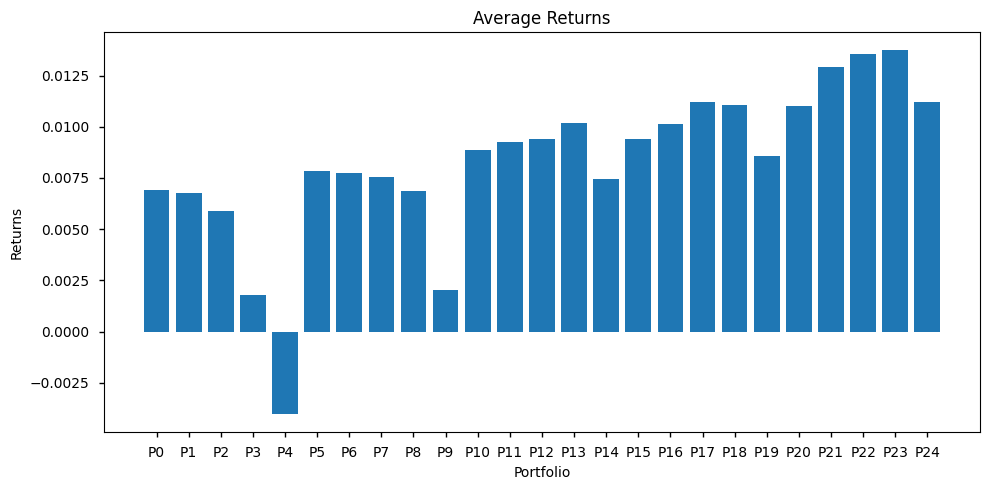

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.bar(
    np.arange(25),
    portfolio_ret.mean(axis=0),
)

ax.set_xlabel("Portfolio")
ax.set_ylabel("Returns")
ax.set_title("Average Returns")

plt.xticks(
    ticks=range(25),
    labels=[f"P{i}" for i in range(25)],
)
plt.tight_layout()
plt.show()


c:\Users\fanghema\Desktop\IVOL-Puzzle-and-Arbitrage-Asymmetry\venv\Lib\site-packages\numpy\lib\_histograms_impl.py:841: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\fanghema\Desktop\IVOL-Puzzle-and-Arbitrage-Asymmetry\venv\Lib\site-packages\numpy\lib\_histograms_impl.py:842: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0.98, 'Return Distribution')

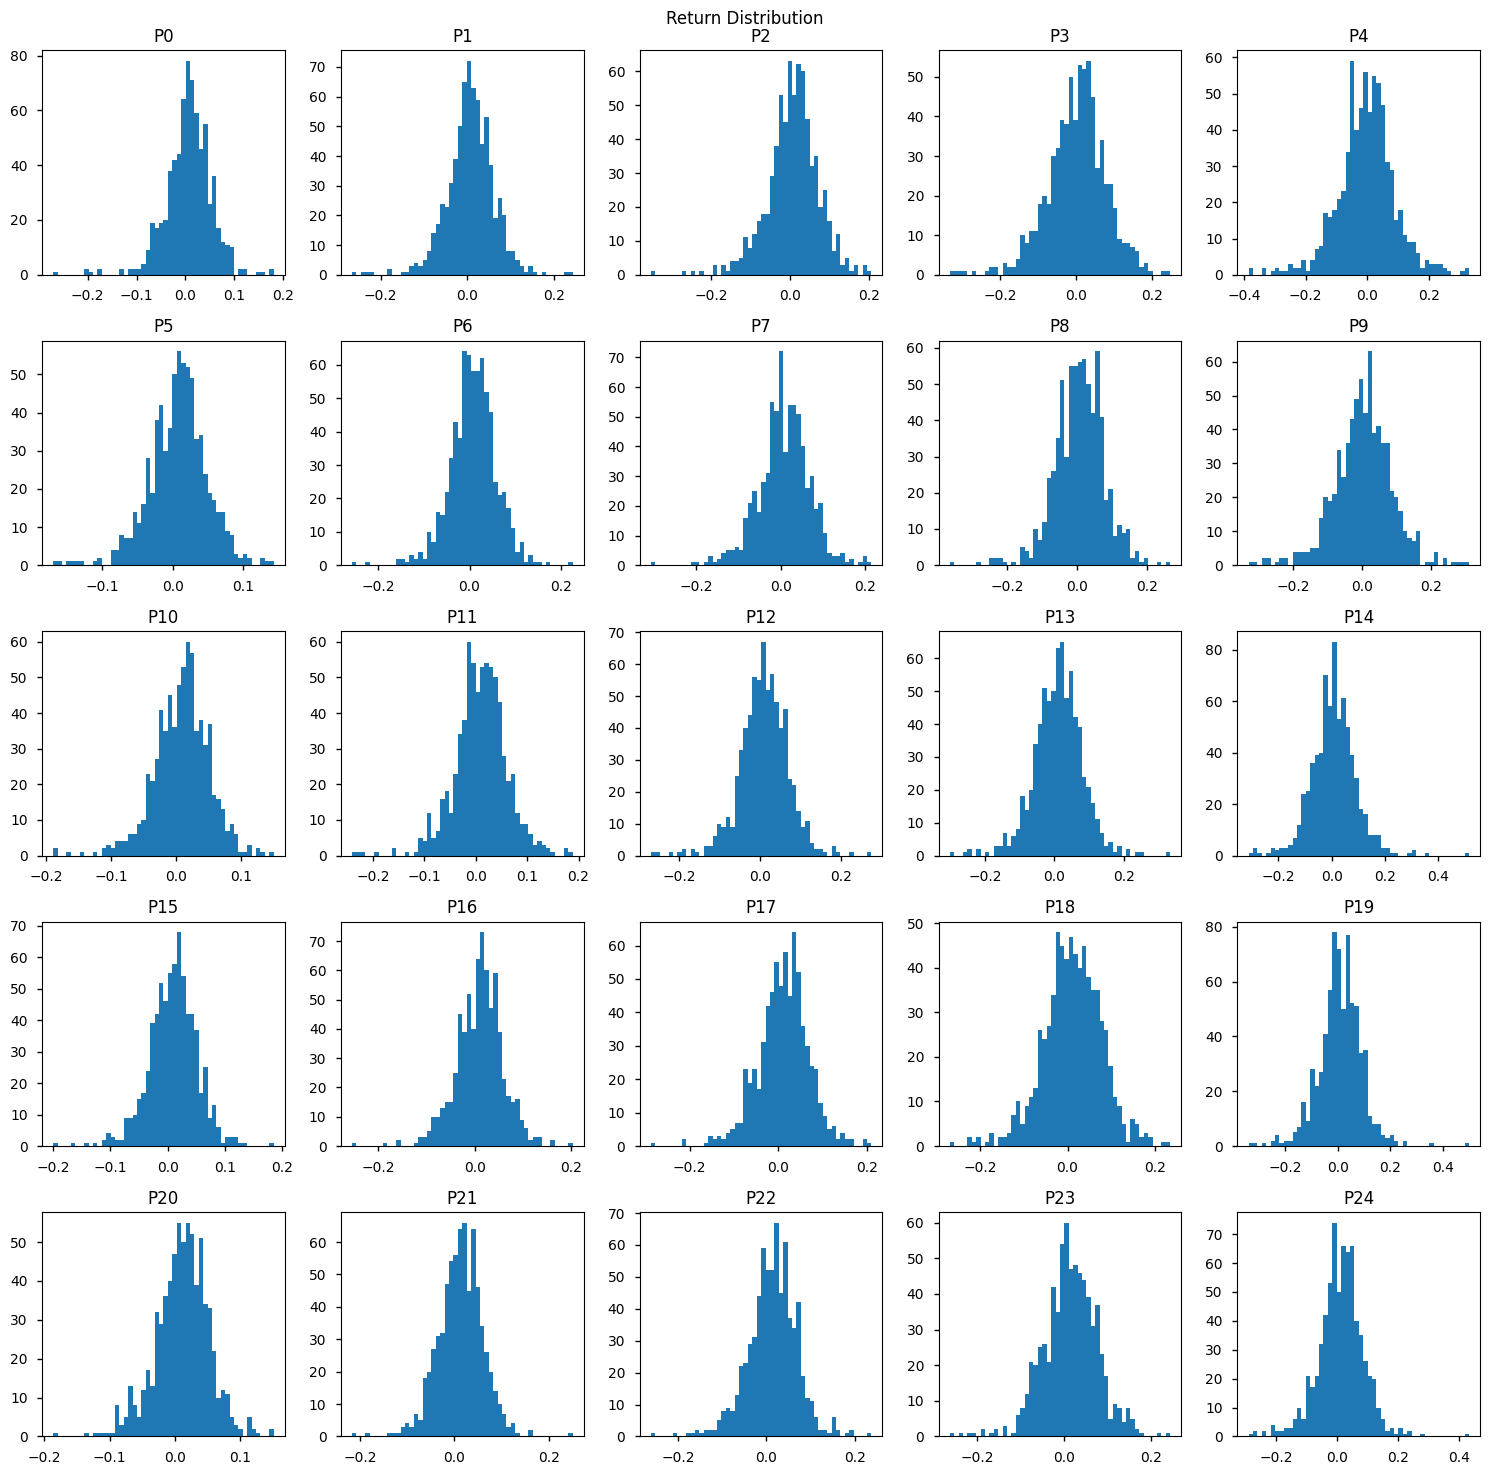

In [44]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15))
axes = np.ravel(axes)

for i, col in enumerate(portfolio_ret.columns):
    axes[i].hist(
        portfolio_ret[col],
        bins = 50,
    )
    axes[i].set_title(f"P{i}")


fig.suptitle("Return Distribution")

Text(0.5, 1.0, 'Compounded returns on 25 value-weighted portfolios')

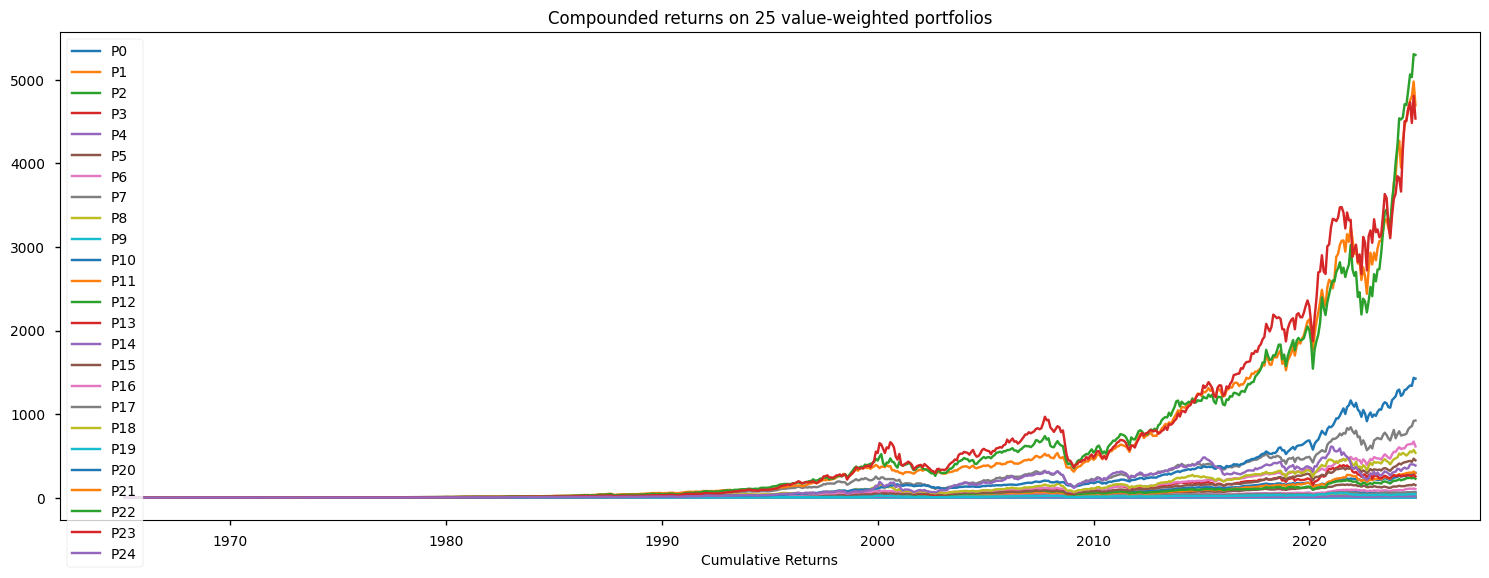

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
for i, col in enumerate(portfolio_ret.columns):
    ax.plot(
        (portfolio_ret[col]+1).cumprod(),
        label = f"P{i}"
    )

ax.legend(loc = 'upper left')

ax.set_xlabel("Date")
ax.set_xlabel("Cumulative Returns")
ax.set_title("Compounded returns on 25 value-weighted portfolios")

In [46]:
factors = (
    conn.raw_sql(
        f"""
        SELECT dateff, mktrf, smb, hml, rf
        FROM ff.factors_monthly
        WHERE dateff BETWEEN '{start}' AND '{end}'
        """,
        date_cols = ['dateff']
    )
    .set_index('dateff')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

factors

,mktrf,smb,hml,rf
dateff,,,,
1965-01-29,0.0354,0.0270,0.0012,0.0028
1965-02-26,0.0044,0.0355,0.0011,0.0030
1965-03-31,-0.0134,0.0189,0.0103,0.0036
1965-04-30,0.0311,0.0110,0.0066,0.0031
1965-05-28,-0.0077,0.0011,-0.0161,0.0031
...,...,...,...,...
2024-08-30,0.0161,-0.0355,-0.0113,0.0048
2024-09-30,0.0174,-0.0017,-0.0259,0.0040
2024-10-31,-0.0097,-0.0101,0.0089,0.0039


In [ ]:
portfolio_ret

In [48]:
portfolio_ret = portfolio_ret.sort_index()
factors = factors.sort_index()

portfolio_ret_reset = portfolio_ret.reset_index().rename(columns={'index': 'date'})
factors_reset = factors.reset_index().rename(columns={'dateff': 'date'})

merged_df = pd.merge_asof(
    portfolio_ret_reset,
    factors_reset,
    on='date',
    direction='backward'  # get the most recent factor date <= portfolio date
)

merged_df.set_index('date', inplace=True)

In [49]:
for i in range(25):
    merged_df[i] -= merged_df['rf']

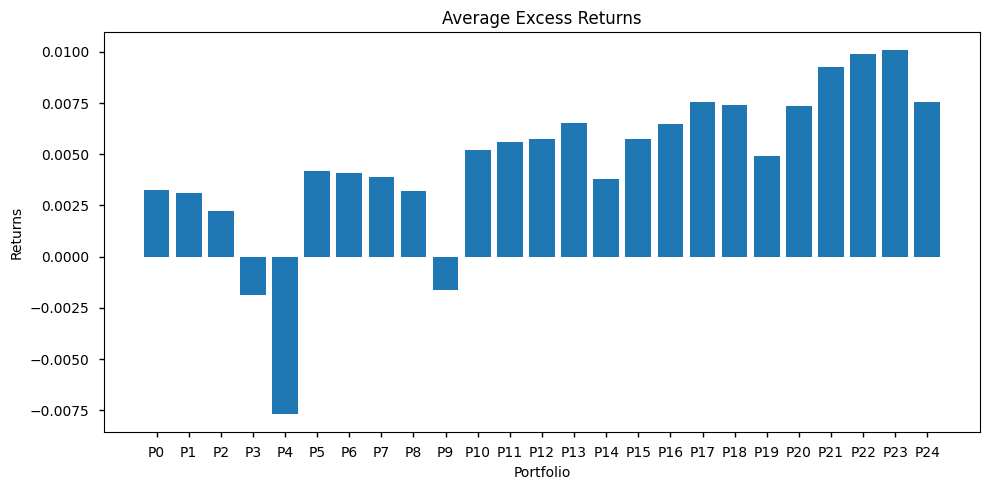

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.bar(
    np.arange(25),
    merged_df[portfolio_ret.columns].mean(axis=0),
)

ax.set_xlabel("Portfolio")
ax.set_ylabel("Returns")
ax.set_title("Average Excess Returns")

plt.xticks(
    ticks=range(25),
    labels=[f"P{i}" for i in range(25)],
)
plt.tight_layout()
plt.show()


In [51]:
alphas = pd.DataFrame({
    "portfolio": np.arange(25),
    "abnormal_ret" : np.zeros(25)
}).set_index('portfolio')

for i in range(25):
    y = np.asarray(merged_df[i])[:-1]
    X = np.asarray(merged_df[['mktrf', 'smb', 'hml']])[:-1]
    X = sm.add_constant(X)
    res = sm.OLS(y, X).fit()
    alphas.loc[i]['abnormal_ret'] = res.params[0]

C:\Users\fanghema\AppData\Local\Temp\ipykernel_8812\39423866.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  alphas.loc[i]['abnormal_ret'] = res.params[0]
C:\Users\fanghema\AppData\Local\Temp\ipykernel_8812\39423866.py:11: FutureWarning

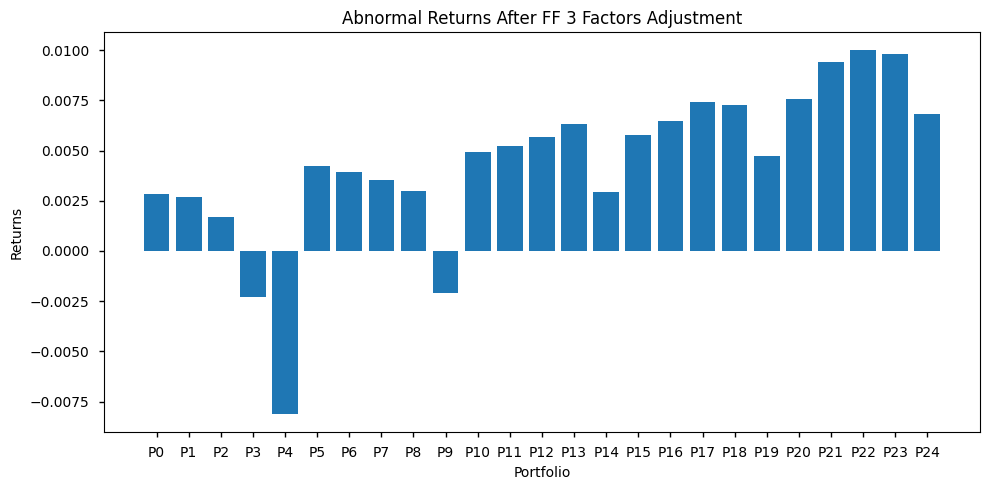

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.bar(
    np.arange(25),
    alphas['abnormal_ret']
)

ax.set_xlabel("Portfolio")
ax.set_ylabel("Returns")
ax.set_title("Abnormal Returns After FF 3 Factors Adjustment")

plt.xticks(
    ticks=range(25),
    labels=[f"P{i}" for i in range(25)],
)
plt.tight_layout()
plt.show()


In [ ]:
# Define range of months to pull
start_date = pd.to_datetime('1965-02-01')
end_date = pd.to_datetime('2025-01-31')
months = pd.date_range(start=start_date, end=end_date, freq='MS')

crsp_daily_rets = []

for month_start in tqdm(months):
    month_end = month_start + MonthEnd(1)
    start_str = month_start.strftime('%Y-%m-%d')
    end_str = month_end.strftime('%Y-%m-%d')

    query = f"""
        SELECT date, permno, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start_str}' AND '{end_str}'
    """
    
    chunk = conn.raw_sql(query)
    crsp_daily_rets.append(chunk)

# Combine all chunks
crsp_daily_rets = pd.concat(crsp_daily_rets)
crsp_daily_rets['date'] = pd.to_datetime(crsp_daily_rets['date'])
crsp_daily_rets = crsp_daily_rets.set_index(['date', 'permno']).sort_index()



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.7 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 57.7/57.7 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.6 MB/s eta 0:00:00


100%|██████████| 720/720 [07:09<00:00,  1.68it/s]
C:\Users\fanghema\AppData\Local\Temp\ipykernel_8812\3036556633.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crsp_daily_rets = pd.concat(crsp_daily_rets)


In [69]:
ff_factors_daily = (
    conn.raw_sql("""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '1965-02-01' AND '2025-01-31'
    """
    )
    .set_index('date')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

ff_factors_daily.index = pd.to_datetime(ff_factors_daily.index)

In [70]:
# crsp_daily_rets.to_csv('./Data/CRSP_daily_rets.csv')
ff_factors_daily.to_csv('./Data/ff_factors_daily.to_csv')

#### Experimenting with running regressions on daily returns of the value-weighted portfolios.

In [74]:
alpha_df = pd.DataFrame(index=portfolio_comp.index[:-1], columns=portfolio_comp.columns, dtype=float)

for formation_month in tqdm(portfolio_comp.index[:-1]):
    next_month_start = formation_month + MonthBegin(1)
    next_month_end = formation_month + MonthEnd(1)
    daily_dates = pd.date_range(next_month_start, next_month_end, freq='B')

    crsp_rets = conn.raw_sql(f"""
        SELECT date, permno, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{next_month_start.strftime('%Y-%m-%d')}' AND '{next_month_end.strftime('%Y-%m-%d')}'
    """)
    crsp_rets['date'] = pd.to_datetime(crsp_rets['date'])
    crsp_rets = crsp_rets.set_index(['date', 'permno'])

    # Loop through all 25 portfolios
    for p in portfolio_comp.columns:
        permnos = portfolio_comp.loc[formation_month, p]
        if len(permnos) == 0:
            continue

        w = market_equity_df.loc[formation_month, permnos].dropna()
        if w.sum() == 0: continue
        w = w / w.sum()

        port_rets = []
        for d in daily_dates:
            try:
                day_rets = crsp_rets.loc[d]
                valid_permnos = w.index.intersection(day_rets.index)
                if len(valid_permnos) == 0:
                    continue
                vw_ret = np.dot(w.loc[valid_permnos], day_rets.loc[valid_permnos, 'ret'])
                port_rets.append((d, vw_ret))
            except KeyError:
                continue

        if len(port_rets) < 10:
            print(f"Too few data points for regression")
            continue  # too few data points to run regression

        port_rets_df = pd.DataFrame(port_rets, columns=['date', 'ret']).set_index('date')
        reg_df = port_rets_df.merge(
            ff_factors_daily, 
            left_index = True, 
            right_index=True, 
            how='left'
        )

        y = np.asarray(reg_df['ret'] - reg_df['rf'])
        X = np.asarray(reg_df[['mktrf', 'smb', 'hml']])
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        alpha_df.loc[formation_month, p] = model.params[0]


100%|██████████| 719/719 [10:02<00:00,  1.19it/s]


C:\Users\fanghema\AppData\Local\Temp\ipykernel_8812\2337875649.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = get_cmap('BuPu')


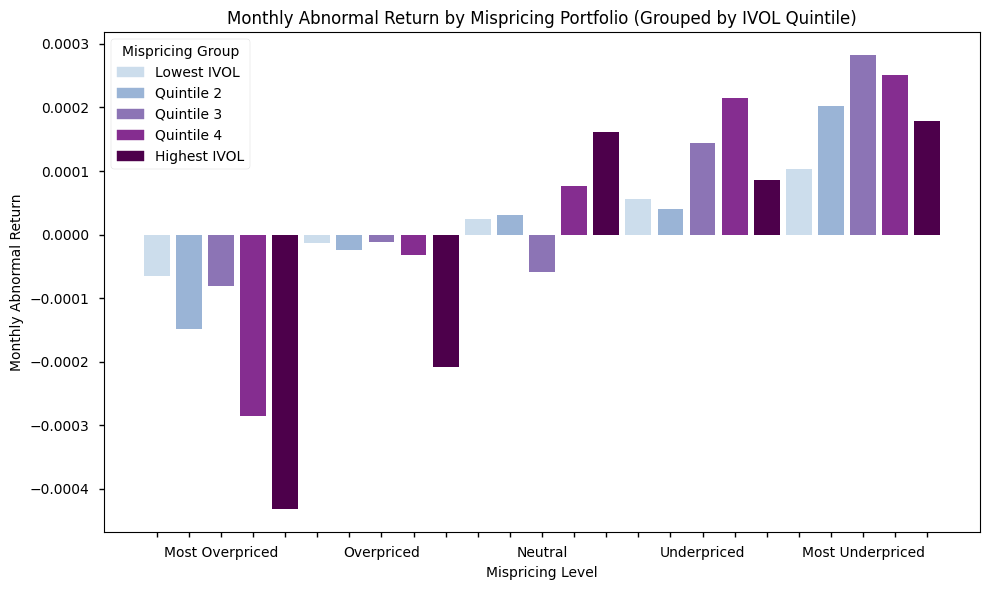

In [96]:
fig, ax = plt.subplots(1,1, figsize = (10, 6))

cm = get_cmap('BuPu')
colors = [cm(i) for i in np.linspace(0.2, 1, 5)]
bar_colors = [colors[i % 5] for i in range(25)]

ax.bar(
    np.arange(25),
    alpha_df.mean(axis=0),
    color = bar_colors
)

ax.set_xlabel('Mispricing Level')
ax.set_ylabel('Monthly Abnormal Return')
ax.set_title('Monthly Abnormal Return by Mispricing Portfolio (Grouped by IVOL Quintile)')
ax.set_xticks(np.arange(25))

group_labels = ['', '', 'Most Overpriced',  '', '',
                '', '', 'Overpriced', '',  '',
                '', '', 'Neutral', '', '',
                '', '', 'Underpriced', '', '',
                '', '', 'Most Underpriced',  '', '']
ax.set_xticklabels(group_labels,ha='center')

legend_handles = [Patch(color=colors[i], label=f'Group {i+1}') for i in range(5)]

legend_handles = [
    Patch(color=colors[i], label=f'Lowest IVOL' if i == 0 else
                              f'Quintile {i+1}' if i < 4 else
                              'Highest IVOL')
    for i in range(5)
]
ax.legend(handles=legend_handles, title='Mispricing Group')

plt.tight_layout()
plt.show()
